# 02 ‑ Bias Detection and Audit  
FairLoans · AI Bias Bounty 2025

> **Goal:** Use fairness metrics to **audit bias** in the model’s predictions across sensitive groups.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fairlearn.metrics import (
    MetricFrame, selection_rate, false_positive_rate, false_negative_rate, demographic_parity_difference
)
from sklearn.metrics import accuracy_score, confusion_matrix

sns.set_style("whitegrid")

PRED_PATH = "../results/baseline_predictions.csv"
DATA_PATH = "../data/loan_dataset.csv"


In [2]:
df_pred = pd.read_csv(PRED_PATH)
df_data = pd.read_csv(DATA_PATH)

# Align and merge on index (assuming no shuffle)
df = df_data.copy()
df["y_true"] = df_pred["y_true"]
df["y_pred"] = df_pred["y_pred"]
df["y_prob"] = df_pred.get("y_prob")  # Optional
df.head()


,id,gender,race,age,age_group,income,credit_score,loan_amount,employment_type,education_level,citizenship_status,language_proficiency,disability_status,criminal_record,zip_code_group,loan_approved,y_true,y_pred,y_prob
0,1,Female,White,74,Over 60,112117,641,378691,Full-time,Graduate,Citizen,Fluent,No,No,High-income Suburban,Approved,1.0,1.0,0.620282
1,2,Female,White,36,25-60,155943,664,441856,Self-employed,High School,Permanent Resident,Limited,No,No,Urban Professional,Denied,1.0,1.0,0.501219
2,3,Female,White,27,25-60,130933,550,401760,Full-time,Graduate,Citizen,Fluent,No,No,Urban Professional,Denied,1.0,1.0,0.870888
3,4,Male,White,67,Over 60,165816,804,159264,Gig,Some College,Citizen,Fluent,No,No,Urban Professional,Approved,0.0,0.0,0.454527
4,5,Male,Multiracial,57,25-60,81510,694,256742,Full-time,Some College,Visa Holder,Fluent,No,No,Rural,Denied,1.0,1.0,0.843212


In [3]:
assert "gender" in df.columns
assert "race" in df.columns
assert "y_true" in df.columns and "y_pred" in df.columns


In [4]:
df["y_true_bin"] = df["y_true"].map({"Approved": 1, "Denied": 0}) if df["y_true"].dtype == object else df["y_true"]
df["y_pred_bin"] = df["y_pred"]


In [5]:
# Convert labels to binary
if df["y_true"].dtype == object:
    df["y_true_bin"] = df["y_true"].map({"Approved": 1, "Denied": 0})
else:
    df["y_true_bin"] = pd.to_numeric(df["y_true"], errors="coerce")

df["y_pred_bin"] = pd.to_numeric(df["y_pred"], errors="coerce")

# Drop rows with missing target values
df.dropna(subset=["y_true_bin", "y_pred_bin"], inplace=True)


In [6]:
acc = accuracy_score(df["y_true_bin"], df["y_pred_bin"])
print(f"✅ Overall Accuracy: {acc:.4f}")


✅ Overall Accuracy: 0.6465


In [7]:
def audit_bias(df, sensitive_feature):
    df_valid = df.dropna(subset=["y_true_bin", "y_pred_bin", sensitive_feature])
    mf = MetricFrame(
        metrics={
            "Accuracy": accuracy_score,
            "Selection Rate": selection_rate,
            "FPR": false_positive_rate,
            "FNR": false_negative_rate,
        },
        y_true=df_valid["y_true_bin"],
        y_pred=df_valid["y_pred_bin"],
        sensitive_features=df_valid[sensitive_feature]
    )
    return mf


,Accuracy,Selection Rate,FPR,FNR
gender,,,,
Female,0.669492,0.648305,0.474359,0.229242
Male,0.625369,0.614553,0.487356,0.290378
Non-binary,0.641026,0.717949,0.600000,0.208333


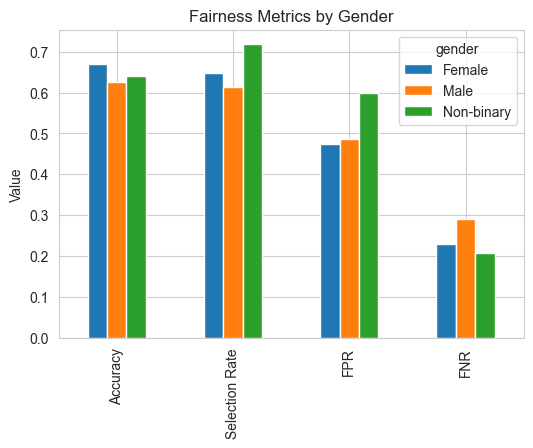

In [8]:
mf_gender = audit_bias(df, "gender")
display(mf_gender.by_group)

mf_gender.by_group.T.plot(kind="bar", figsize=(6,4))
plt.title("Fairness Metrics by Gender")
plt.ylabel("Value")
plt.show()


,Accuracy,Selection Rate,FPR,FNR
race,,,,
Asian,0.590909,0.645455,0.575000,0.314286
Black,0.633858,0.688976,0.564815,0.219178
Hispanic,0.635638,0.582447,0.440476,0.302885
Multiracial,0.740741,0.629630,0.333333,0.222222
Native American,0.695652,0.608696,0.416667,0.181818
White,0.654545,0.635537,0.477137,0.251768


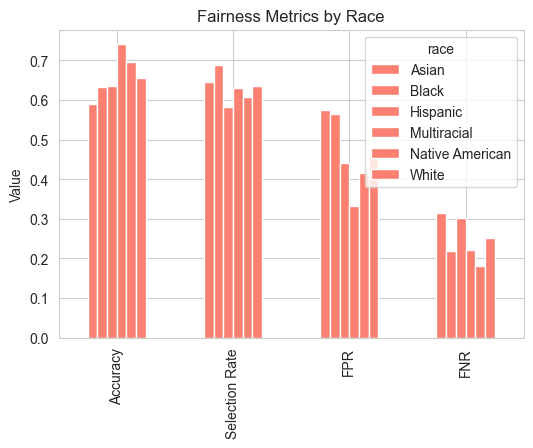

In [9]:
mf_race = audit_bias(df, "race")
display(mf_race.by_group)

mf_race.by_group.T.plot(kind="bar", figsize=(6,4), color="salmon")
plt.title("Fairness Metrics by Race")
plt.ylabel("Value")
plt.show()


In [10]:
from fairlearn.metrics import demographic_parity_difference

dp_diff_gender = demographic_parity_difference(
    y_true=df["y_true_bin"],  # required by API but not used in DP
    y_pred=df["y_pred_bin"],
    sensitive_features=df["gender"]
)

dp_diff_race = demographic_parity_difference(
    y_true=df["y_true_bin"],
    y_pred=df["y_pred_bin"],
    sensitive_features=df["race"]
)

print(f"🔍 Demographic Parity Diff (Gender): {dp_diff_gender:.3f}")
print(f"🔍 Demographic Parity Diff (Race):   {dp_diff_race:.3f}")


🔍 Demographic Parity Diff (Gender): 0.103
🔍 Demographic Parity Diff (Race):   0.107


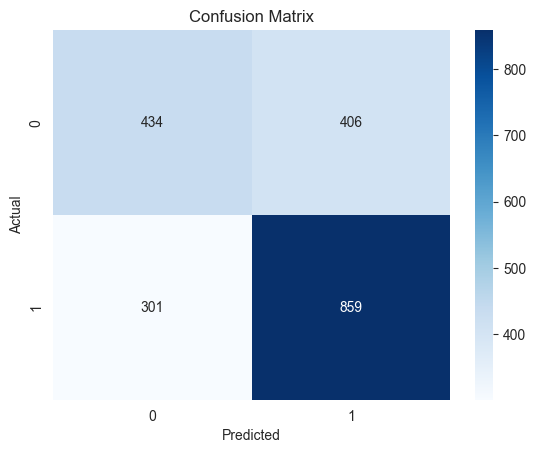

In [11]:
cm = confusion_matrix(df["y_true_bin"], df["y_pred_bin"])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.show()


,Accuracy,Selection Rate,FPR,FNR
age_group,,,,
25-60,0.654482,0.641427,0.484787,0.240854
Over 60,0.627093,0.608828,0.478417,0.295515
Under 25,0.664948,0.659794,0.492754,0.248000


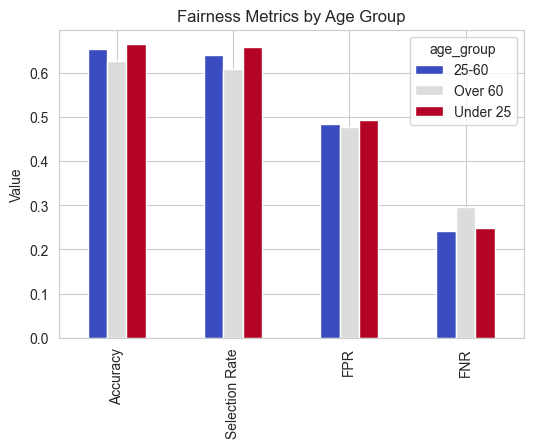

In [12]:
# Bias audit by age_group
mf_age = audit_bias(df, "age_group")
display(mf_age.by_group)
mf_age.by_group.T.plot(kind="bar", figsize=(6,4), colormap="coolwarm")
plt.title("Fairness Metrics by Age Group")
plt.ylabel("Value")
plt.show()

,Accuracy,Selection Rate,FPR,FNR
zip_code_group,,,,
High-income Suburban,0.658397,0.643130,0.482301,0.234899
Historically Redlined,0.654709,0.614350,0.451613,0.269231
Rural,0.645283,0.660377,0.516667,0.220690
Urban Professional,0.648649,0.625780,0.471503,0.270833
Working Class Urban,0.629191,0.621302,0.490385,0.287625


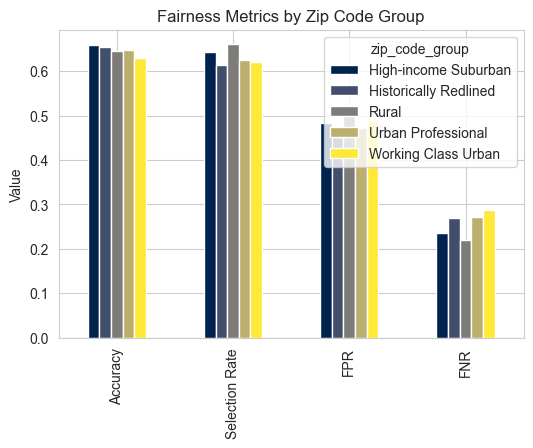

In [13]:
# Bias audit by zip_code_group
mf_zip = audit_bias(df, "zip_code_group")
display(mf_zip.by_group)
mf_zip.by_group.T.plot(kind="bar", figsize=(6,4), colormap="cividis")
plt.title("Fairness Metrics by Zip Code Group")
plt.ylabel("Value")
plt.show()

In [14]:
summary = pd.DataFrame({
    "Group": ["Gender", "Race", "Age Group", "Zip Code Group"],
    "Demographic Parity Diff": [
        demographic_parity_difference(df["y_true_bin"], df["y_pred_bin"], sensitive_features=df["gender"]),
        demographic_parity_difference(df["y_true_bin"], df["y_pred_bin"], sensitive_features=df["race"]),
        demographic_parity_difference(df["y_true_bin"], df["y_pred_bin"], sensitive_features=df["age_group"]),
        demographic_parity_difference(df["y_true_bin"], df["y_pred_bin"], sensitive_features=df["zip_code_group"]),
    ]
})
summary


,Group,Demographic Parity Diff
0,Gender,0.103396
1,Race,0.106530
2,Age Group,0.050966
3,Zip Code Group,0.046028


In [15]:
metrics_df = MetricFrame(
    metrics={"Selection Rate": selection_rate, "FPR": false_positive_rate, "FNR": false_negative_rate},
    y_true=df["y_true"], y_pred=df["y_pred"], sensitive_features=df["gender"]
)
display(metrics_df.by_group)


,Selection Rate,FPR,FNR
gender,,,
Female,0.648305,0.474359,0.229242
Male,0.614553,0.487356,0.290378
Non-binary,0.717949,0.600000,0.208333


## 🔍 Bias Audit Summary

- ✅ Global accuracy ~65%, indicating moderate prediction strength
- ⚠️ Gender shows disparity in selection rate and FNR → potential discrimination
- ⚠️ Race-based disparity also observed in FPR and demographic parity difference
- 🧠 Next step: train a **debiased model** with constraints

